# Trials with FeatUp
FeatUp is a framework for vision model feature upsampling.

In [1]:
%load_ext autoreload
%autoreload 2

from End2End_Model import End2End_Model
from DINO import VisionTransformer
from functools import partial
from torch import nn
import torch
from featup.plotting import plot_feats

## Setup

Original `FeatUp` repository provides only pre-trained models and doesn't explain how to use their API with other models. </br>
Hovewer, this framework consist on separate ViT Backbone and Upscaler. Their ViT is backbone is enriched in few methods which enable features extraction. </br>
I reason that the simplest solution is to take my weights fine-tuned on LIDC and inject them into their ViT implementation.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=True).to(device)

Using cache found in /home/dzban112/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main


In [4]:
upsampler.model[0].model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

I load checkpoint of a fine-tuned equivalent model and I extract `state_dict` from it.

In [20]:
ckpt_path="/home/dzban112/LIDC_ViTs/ckpt/End2End/"+"dino_vits16_32_1.ckpt"

In [21]:
my_weights = torch.load(ckpt_path)

However, weights from my checkpoint has slightly different names/keys. There is need to rekey weights, to match an original architecture.

In [22]:
list(my_weights["state_dict"].keys())[:5]

['backbone.cls_token',
 'backbone.pos_embed',
 'backbone.patch_embed.proj.weight',
 'backbone.patch_embed.proj.bias',
 'backbone.blocks.0.norm1.weight']

In [23]:
# rekeying weights
my_weights={k.replace("backbone.", ""): v for k, v in my_weights["state_dict"].items()}
# Avoiding head weights
my_weights = {k: v for k, v in my_weights.items() if "head." not in k}

In [24]:
list(my_weights.keys())[:5]

['cls_token',
 'pos_embed',
 'patch_embed.proj.weight',
 'patch_embed.proj.bias',
 'blocks.0.norm1.weight']

Finally, fine-tuned weights might be injected into their architecture:

In [25]:
upsampler.model[0].model.load_state_dict(my_weights)

<All keys matched successfully>

## Inference

In [26]:
from my_utils.loading_data_utils import load_img
import os
import pickle
import matplotlib.pyplot as plt

In [27]:
current_directory = os.getcwd()
with open(current_directory+"/dataset/splitted_sets/fitted_factors.pkl", 'rb') as f:
    fitted_factors = pickle.load(f)

In [84]:
NODULE="0123.pt"

In [85]:
# Taking mean and std from fitted factors
MEAN, STD, SCALER = fitted_factors["fold_1"]
# Loading image from repository:
img, original_img = load_img(crop_path=current_directory + f"/dataset/crops/{NODULE}", 
                                 crop_view="axial", 
                                 slice_=16,
                                 MEAN=MEAN,
                                 STD=STD, 
                                 device="cuda")

In [86]:
hr_feats = upsampler(img)

In [87]:
lr_feats = upsampler.model(img)

[rank: 0] Seed set to 0


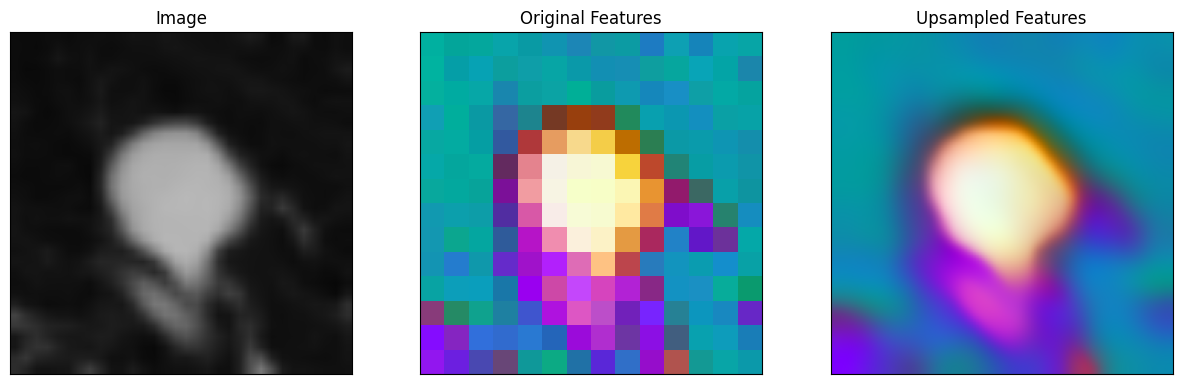

In [88]:
plot_feats(original_img.movedim(2,0), lr_feats[0], hr_feats[0])

## Below Trash

In [48]:
from featup.featurizers.DINO import DINOFeaturizer

In [13]:
model = DINOFeaturizer("vit_small_patch16_224", patch_size=16, feat_type="key").to(device)

In [15]:
out = model(img)

In [16]:
out.shape

torch.Size([1, 384, 14, 14])

In [17]:
model

DINOFeaturizer(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Laye

In [36]:
from featup.util import pca, remove_axes

In [37]:
[lr_feats_pca, hr_feats_pca], _ = pca([lr_feats, hr_feats])

In [39]:
lr_feats_pca.shape

torch.Size([1, 3, 14, 14])

In [41]:
hr_feats_pca.shape

torch.Size([1, 3, 224, 224])

In [44]:
feats_lst = [lr_feats, hr_feats]

In [46]:
target_size = feats_lst[0].shape[2]

In [47]:
target_size

14

In [50]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import defaultdict, deque
import torch
import torch.nn as nn

In [64]:
def flatten(tensor, target_size=None):
    fit_pca=None
    if target_size is not None and fit_pca is None:
        tensor = F.interpolate(tensor, (target_size, target_size), mode="bilinear")
    B, C, H, W = tensor.shape
    return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

In [65]:
out = flatten(lr_feats, 14)

In [66]:
out.shape

torch.Size([196, 384])

In [62]:
out2 = flatten(hr_feats, 14)

In [63]:
out2.shape

torch.Size([1, 384, 14, 14])